In [2]:


import matplotlib.pyplot as plt
from scipy.io import wavfile
from pydub import AudioSegment
import numpy as np
import struct

import torch
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
# from model import Net
import os
import random


In [17]:

def draw(file, answer):
    frame_rate = file.frame_rate
    raw_data = file.get_array_of_samples()
    # plt.figure(figsize=(20, 3))
    # plt.plot(r)
    # plt.show()
    result = []
    # t = (frame_rate / 1000 * 250)
    # for i in range(int(len(raw_data) / t) - 1):
    r = file.get_array_of_samples()
    freq_sepctrum = np.fft.fft(r)
    freq = np.fft.fftfreq(len(freq_sepctrum), d= 1 / frame_rate)
    len_data = int(len(freq) / 2)
    x = freq[:len_data][:1024]
    raw = np.abs(freq_sepctrum[:len_data])[:1024]
    # plt.figure(figsize=(10,3)); plt.plot(x, y); plt.show()
    y = (raw - raw.min()) / (raw.max() - raw.min())
    result.append({"data": torch.from_numpy(np.array(y).astype('float32')), "answer": torch.from_numpy(np.array(answer)), "raw":raw})
    return result


In [18]:
close_path = './audio/close'
open_path = './audio/open'
walk_path = './audio/walk'

door_close = os.listdir(close_path)
door_open = os.listdir(open_path)
door_walk = os.listdir(walk_path)

door_close = list(map(lambda x: os.path.join(close_path, x), door_close))
door_open = list(map(lambda x: os.path.join(open_path, x), door_open))
door_walk = list(map(lambda x: os.path.join(walk_path, x), door_walk))


In [19]:
print(len(os.listdir(close_path)))
print(len(os.listdir(open_path)))
print(len(os.listdir(walk_path)))

206
205
227


In [20]:
def conv(x, y):
    x1 = AudioSegment.from_file(x)
    r = draw(x1, y)
    return r

fft_close = np.array(list(map(lambda x: conv(x, 0), door_close)))
fft_open = np.array(list(map(lambda x: conv(x, 1), door_open)))
fft_walk = np.array(list(map(lambda x: conv(x, 2), door_walk)))


In [21]:
fft_close = fft_close.reshape(len(fft_close))
fft_open = fft_open.reshape(len(fft_open))
fft_walk = fft_walk.reshape(len(fft_walk))

In [22]:
vv1 = np.append(fft_close, fft_open)
vv1 = np.append(vv1, fft_walk)
print(len(vv1))

638


In [56]:

device = torch.device("cuda")

train_kwargs = {'batch_size': 1}
test_kwargs = {'batch_size': 1}
cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': True}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(3136, 1000)    # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [58]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, elem in enumerate(train_loader):
        data, target = elem["data"], elem["answer"]
        data = data[:784].reshape((1,1,28,28))
        target = target.reshape((1))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(data), len(train_loader),
                100. * idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, elem in enumerate(test_loader):
            data, target = elem["data"], elem["answer"]
            data = data[:784].reshape((1,1,28,28))
            target = target.reshape((1))
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader),
        100. * correct / len(test_loader)))
    return (test_loss, 100. * correct / len(test_loader))


In [24]:
def draw_conv(data):
    raw_sum = data[0]['data']
    min_sum = data[0]['raw'].copy()
    max_sum = data[0]['raw'].copy()
    for item in range(1, len(data)):
        raw_sum += data[item]['data']
        for i in range(len(data[item]['data'])):
            min_sum[i] = min(min_sum[i], data[item]['raw'][i])
            max_sum[i] = max(max_sum[i], data[item]['raw'][i])
        
    
    raw_sum /= len(data)
    return (raw_sum, min_sum, max_sum)
        

In [25]:
a1, mia1, maa1 = draw_conv(fft_close)
a2, mia2, maa2 = draw_conv(fft_open)
a3, mia3, maa3 = draw_conv(fft_walk)


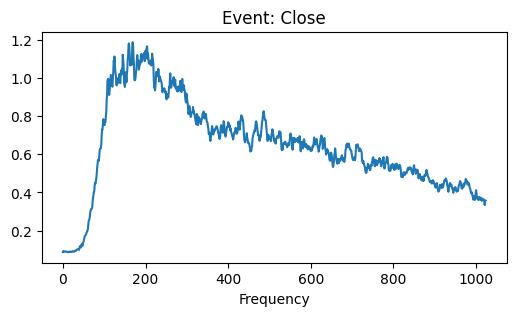

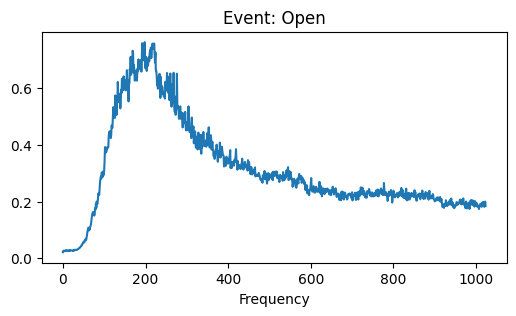

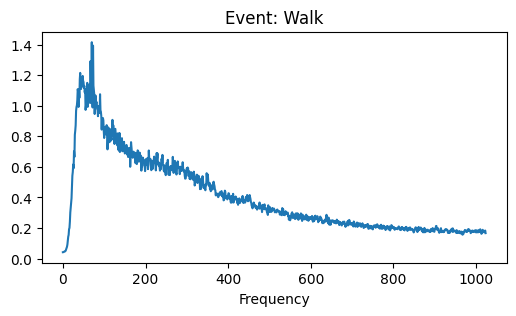

In [46]:

plt.figure(figsize=(6,3))
plt.title("Event: Close")
plt.xlabel("Frequency")
plt.plot(a1)
plt.show()

plt.figure(figsize=(6,3))
plt.title("Event: Open")
plt.xlabel("Frequency")
plt.plot(a2)
plt.show()

plt.figure(figsize=(6,3))
plt.title("Event: Walk")
plt.xlabel("Frequency")
plt.plot(a3)
plt.show()

In [27]:
model = Net()
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)

In [304]:
# a = 

In [31]:
print(model(a3[:784].reshape((1,1,28,28))).argmax())
print(model(a2[:784].reshape((1,1,28,28))).argmax())
print(model(a1[:784].reshape((1,1,28,28))).argmax())


tensor(2)
tensor(2)
tensor(2)


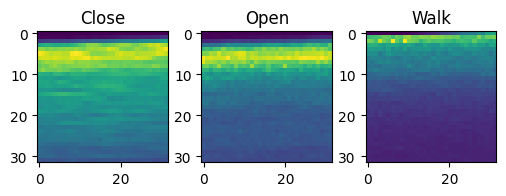

In [32]:
zero = None
one = None
two = None

zero_cnt = 0
one_cnt = 0
two_cnt = 0

for i in vv1:
    if i['answer'] == 0:
        zero_cnt += 1
        if zero == None:
            zero = i['data']
        else:
            zero += i['data']
    elif i['answer'] == 1:
        one_cnt += 1
        if one == None:
            one = i['data']
        else:
            one += i['data']
    elif i['answer'] == 2:
        two_cnt += 1
        if two == None:
            two = i['data']
        else:
            two += i['data']    

        
plt.figure(figsize=(6, 1.7))
plt.subplot(1,3,1)
plt.title('Close')
plt.imshow((zero / zero_cnt).reshape((32,32)))
# plt.show()
plt.subplot(1,3,2)
plt.title('Open')
plt.imshow((one / one_cnt).reshape((32,32)))

plt.subplot(1,3,3)
plt.title('Walk')
plt.imshow((two / two_cnt).reshape((32,32)))
plt.show()


In [66]:

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
random.shuffle(vv1)
val = int(len(vv1) / 5 * 4)
train_set = vv1[:val]
test_set = vv1[val:]

loss = []
acc = []


for epoch in range(1000):
    random.shuffle(vv1)
    random.shuffle(train_set)
    random.shuffle(test_set)
    train(model, device, vv1[:val], optimizer, epoch)
    l, a = test(model, device, vv1[val:])
    loss.append(l)
    acc.append(a)
    scheduler.step()
torch.save(model.state_dict(), "mnist_cnn.pt")


Train Epoch: 0 [0/510 (0%)]	Loss: 1.110284
Train Epoch: 0 [10/510 (2%)]	Loss: 0.015851
Train Epoch: 0 [20/510 (4%)]	Loss: 1.026031
Train Epoch: 0 [30/510 (6%)]	Loss: 1.097151
Train Epoch: 0 [40/510 (8%)]	Loss: 0.996707
Train Epoch: 0 [50/510 (10%)]	Loss: 0.841117
Train Epoch: 0 [60/510 (12%)]	Loss: 1.137570
Train Epoch: 0 [70/510 (14%)]	Loss: 0.575177
Train Epoch: 0 [80/510 (16%)]	Loss: 0.796036
Train Epoch: 0 [90/510 (18%)]	Loss: 0.879770
Train Epoch: 0 [100/510 (20%)]	Loss: 0.907195
Train Epoch: 0 [110/510 (22%)]	Loss: 0.886321
Train Epoch: 0 [120/510 (24%)]	Loss: 1.037213
Train Epoch: 0 [130/510 (25%)]	Loss: 0.377050
Train Epoch: 0 [140/510 (27%)]	Loss: 0.001765
Train Epoch: 0 [150/510 (29%)]	Loss: 0.768013
Train Epoch: 0 [160/510 (31%)]	Loss: 0.280700
Train Epoch: 0 [170/510 (33%)]	Loss: 0.226649
Train Epoch: 0 [180/510 (35%)]	Loss: 0.000095
Train Epoch: 0 [190/510 (37%)]	Loss: 0.003304
Train Epoch: 0 [200/510 (39%)]	Loss: 0.050006
Train Epoch: 0 [210/510 (41%)]	Loss: 0.229943
Trai

In [55]:
model = Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
m = model.cpu()
m.eval()
x = torch.randn(1,1,28,28, requires_grad=True).cpu().reshape((1,1,28,28))



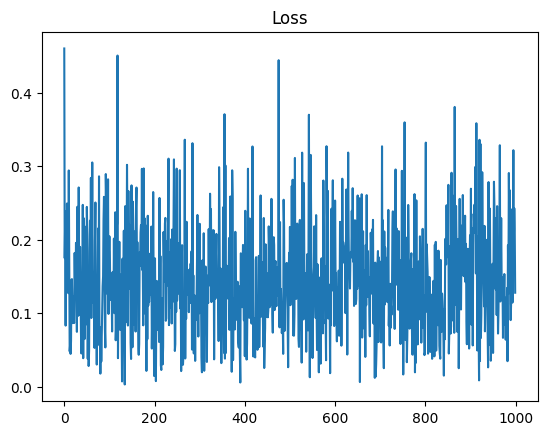

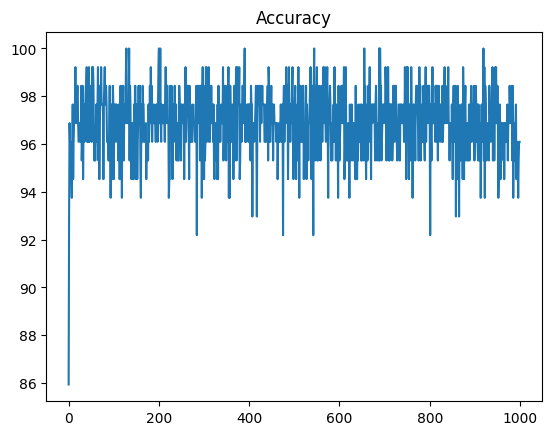

In [67]:

plt.title("Loss")
plt.plot(loss)
plt.show()

plt.title("Accuracy")
plt.plot(acc)
plt.show()


In [12]:

# 모델 변환
torch.onnx.export(m,               # 실행될 모델
                  x,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "sss.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=8,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적화시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output'], # 모델의 출력값을 가리키는 이름
                  )

=========== Diagnostic Run torch.onnx.export version 2.1.0a0+29c30b1 ===========
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [98]:

!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python